# 1. Tutorial: Create iML1515 GECKO

## General: 
In this set of tutorials you will learn to use the f2xba package to create and modify extended genome scale models, such as enzyme constraint GECKO (Sánchez, et al. 2017) models, resource balance constraint RBA (Bulović, et al. 2019; Goelzer, et al. 2011) models and thermodynamics constraint FBA (TFA) (Henry, et al. 2007; Salvy, et al. 2019), GECKO (TGECKO) and RBA (TRBA) models. This will be done by extending iML1515 (Monk, et al. 2017), the latest genome scale metabolic network reconstruction of Escherichia coli. 
You will also learn how to optimize extended genome scale models and how to process the optimization results, which are tasks supported by f2xba. 

While the tutorials includes both model creation and model optimization, these tasks are independent of each other. The model creation task will always create a stand-alone model coded in SBML (Hucka, et al. 2019), https://sbml.org . SBML is a standardized format which facilitates sharing of models and which is supported by many modeling and optimization tools. The SBML coded models can subsequently be loaded, optimized and analyzed with help of f2xba package.

Optimization of an extended genome scale model not only determines values for the reaction fluxes, as in flux balance analysis, but also values for protein concentrations. We will use several minimal media conditions for model optimization with respect to maximum growth rate (Adadi, et al. 2012). Predicted growth rates will be compared against measured growth rates. However, mainly we will focus on predicted vs. measured protein mass levels (Schmidt, et al. 2016).

Model optimization can be done using COBRApy (Ebrahim, et al. 2013a), which is a widely used package supporting genome scale model optimizations related to flux balance analysis (FBA). GECKO models can still be optimized using an open-source solver, like GLPK. More complex models might require high-quality commercial solver such as Gurobi or IBM CPLEX. Solvers should support both linear programming and mixed integer linear programming.

Requirement: The `f2xba` modelling package needs to be installed from PyPI, e.g. via `pip --install f2xba`,  this also installs sbmlxdf and libSBML (Bornstein, et al. 2008). COBRApy is required for model optimization, which uses Optlang (Jensen, et al. 2017) to connect to different solvers. Optionally, gurobipy with Gurobi solver can be used, which has a better performance. See https://www.gurobi.com for licensing options and installation process. Note: At the time of writing, COBRApy (ver. 0.29.1) using Optlang (1.8.2) does not support latest Gurobi 12, due to incompatibilities in Optlang, instead use Gurobi 11 or lower versions.)

Note: iML1515 is a well curated and annotated model, which facilitates the automated creation of extended models with limited manual configuration. Gene identifiers, used in the model, match with locus tags from the genome annotation, making it possible to automatically retrieve required data from NCBI genome and UniProt (The UniProt 2023) protein databases. Metabolites in the model are already linked to identifies in external databases. This will be exploited by f2xba, which uses KEGG (Kanehisa and Goto 2000) compound ids for retrieving predicted turnover numbers from TurNuP web portal (Kroll, et al. 2023) or link metabolites to thermodynamics data via SEED (Henry, et al. 2010) ids.

There exist genome scale metabolic network reconstructions for many other organisms. Some of them do not yet include the linkages expected by the f2xba modelling tool e.g., gene identifiers do not match to locus tags on a genome annotation or metabolites are not yet linked to external databases. In such case the original genome scale model needs to be updated and the missing links need to be created. Such task is supported by the Python package sbmlxdf.

**If you quickly want to generate a GECKO model of iML1515, you don’t need to read through all the text and background information.**

## This tutorial

In this 1st tutorial you will see how fast and easy it is to create an enzyme constraint GECKO model based on an existing genome scale metabolic model (FBA model). The GECKO model will be implemented according to the GECKO formulation (Sánchez, et al. 2017), with minor adjustments, which, we think, benefit the model structure. This first model mainly uses default parametrization, therefore very little manual configuration is required. Manual configurations will be coded explicitly. Alternatively, configuration files can be created and managed using a spreadsheet program, like Microsoft Excel.
 
The model will be coded in standardized SBML and saved to file. COBRApy will be used to load and optimize the model across various growth conditions. We also provide code for loading and optimizing extended models using the gurobipy interface. Optimization results will be processed and analyzed using functions of f2xba. 

This first model will have a poor prediction performance. We will concentrate on predicting measured protein concentrations for our reference condition glucose. In subsequent tutorials we try improving the model configuration to improve prediction quality. 

Note: We executed the jupyter notebooks under following environment: MacBook Pro 2019, 2.4 GHz 8-Core Intel Core i9, 16 GB RAM,  macOS Sonoma 14.6.1, Python 3.10/3.11, COBRAPy 0.27.0, IBM cplex 22.1.1.0 (Python 3.10), Gurobi 11.0.2.

Now, let’s start!

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (M. Lercher), November, 2024

### solver interface performance for complex models

Model loading and optimization are significantly faster using the gurobipy interface when working with complex models, here a thermodynamics enabled RBA model of iML1515 (iML1515_TRBA.xml). COBRApy adds significant overhead. 
Less complex models have similar loading and optimization times, therefore we used the well known COBRApy interface for most of our model optimization tasks and provide code for guribipy interface as an alternative. Using COBRApy interface for model optimization of RBA and TRBA models requires an addional model loading step when creating the RbaOptimization instance, as we need to access SBML core objects that COBRApy are cannot access.

Below measurements relate to optimization across 6 different growth conditions executed on MacBook Pro 2019 laptop, 2.4 GHz 8-Core Intel Core i9, 16 GB RAM, macOS Sonoma 14.6.1, Python 3.10/3.11, COBRAPy 0.27.0, IBM cplex 22.1.1.0 (Python 3.10), Gurobi 11.0.2

|Interface|loading|optimization|
|---------|-------|------------|
|COBRApy  |  172 s|      1225 s|
|gurobipy |   37 s|       195 s|

## Step 1: Initial Setup

1.1 create directory structure  
1.2 download iML1515.xml (*E. coli* genome scale metabolic model) from BiGG Models database  
1.3 import required packages and set model names  

### 1.1 create directory structure
The working directory `.` should contain:
1. jupyter notebooks for this tutorial
2. a proteomics file named `Ecoli_Schmidt_proteomics.xlsx`, which is based on quantitative proteomics from Schmidt, *et al.* 2016 
3. a thermodynamic database `thermo_data.thermodb`, which is used by pyTFA (Salvy, *et al.* 2019), downloaded from https://github.com/EPFL-LCSB/pytfa/blob/master/data/thermo_data.thermodb.

Following directories will be required: 
- `./data`: data files required for model generation, including model configuration files
- `./SBML_models`: models coded in SBML
- `./xlsx_models`: models converted to table format and stored in Excel spreadsheet format
- `./escher`: reaction fluxes, protein and metabolite concentrations stored in a format compliant with Escher maps
- `./plots`: growth rates and proteomics correlation plots stored in PDF format
- `./tmp`: temporary files, which can be deleted

In [1]:
# Create directory structure
import os

for directory in ['data', 'SBML_models', 'xlsx_models', 'escher', 'plots', 'tmp']:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f'{directory} created')

### 1.2 download iML1515.xml 

- go to BiGG Models (http://bigg.ucsd.edu/models/iML1515); Model: *i*ML1515 of *E. coli* str. K-12 substr. MG1655
- under ‘Download COBRA model from the BiGG Database’, download SBML: `iML1515.xml`
- store the model in subdirectory `./SBML_models`

### 1.3 import required packages and set model names

required imports:
- `f2xba.XbaModel`: Main class in extended modelling, managing the model extension process, starting from a genome scale metabolic (FBA) model. Also managing data from external resources, like UniProt.
- `f2xba.EcModel`: specific class for enzyme constraint modelling, such as creation of GECKO models.
- `f2xba.utils.mapping_utils.write_parameter_file`: a helper function to write parameter files.

model names:
- `fba_model`: the name of our original genome scale metabolic model that we extend (without `.xml`).
- `target_model`: the name of the extended model.

In [2]:
# Required imports and model names
import os
import pandas as pd

from f2xba import XbaModel, EcModel
from f2xba.utils.mapping_utils import write_parameter_file

# Model names
fba_model = 'iML1515'
target_model = 'iML1515_default_GECKO'

## Step 2: Create configuration files

Extended models require additional parameters, such as enzyme turnover numbers or stoichiometries of enzyme composition. Finding ‘good’ values for these parameters is one of the major problems associated with generation of extended models. The f2xba modelling tool can help by automating part of this process. 

Parameter values can be defined in configuration files (Excel spreadsheet format). They can also be retrieved automatically from databases, as long there exists proper referencing.

Our first GECKO model of iML1515 shall be created with minimal configuration:  
2.1 create XBA configuration file  
2.2 create ECM configuration file

Once we have our first GECKO model, we will try to modify certain parameter values to achieve ‘better’ model predictions (see subsequent tutorials).

Note: Parameter file creation and modification will be coded in Python. However, users might find it more convenient to create and modify configuration files directly using a spreadsheet application like Microsoft Excel.

### 2.1 create XBA configuration file

We always start the creation of an extended model with the instantiation and configuration of a XbaModel instance. This instance reads in the original SBML coded genome scale model (FBA) model and downloads online resources related to the model, such as UniProt protein data. Downloaded data will be stored in the `./data` directory. Further, enzyme catalyzed reactions get split in forward/reverse directions and split per catalyzing isoenzymes. This is required to couple any flux through a given reaction to an allocation requirement of the corresponding enzyme or isoenzyme. 

The **XBA configuration file** for our first GECKO model contains following data tables and data:
- `generals` table with parameters:
    - `default_metabolic_kcat`: default kcat value (turnover number) for metabolic enzymes in s-1.
    - `default_transporter_kcat`: default kcat value for transporters. Here, transporters are defined as enzymes catalyzing reactions, were reactants/products of different compartments participate.
    - `organism_dir`: directory where organism specific data, downloaded from online databases, will be stored.
    - `organism_id`: the NCBI taxonomic id of the organism. Used to retrieve protein data from UniProt. 
    - `biocyc_org_prefix`: organism id in BioCyc database (Karp, et al. 2017). When provided, enzyme composition will be loaded from BioCyc, otherwise enzyme composition will default to 1 unit of participating protein.
- `remove_gps` table 
    - this table contains records with gene products to be removed from the original model. Here, we remove the dummy protein `G_s0001`, which is used in the FBA model for some spontaneous (iso-)reactions. 
    - configuration tables can contain additional columns, which will not be used by f2ba. Here, we add a `notes` column with information on the specific record.

GECKO models for **other organisms**:
- `organism_id` can be queried from the NCBI the taxonomy database (Schoch, et al. 2020) (https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi). Note, that gene products in the model need to link to the corresponding UniProt records, either via a UniProt annotation reference on the gene product in the FBA model or via a matching gene locus id. 
- There will be situations, where the organism in questions has no related UniProt entries. What can we do? One solution would be to manually generate a pseudo-UniProt file e.g., based on a protein BLAST, and store it in `./data`. Alternatively, f2xba can extract protein related information from NCBI genome data. See tutorial on RBA how to configure retrieval of NCBI genome data.
- `biocyc_org_prefix` should only be configured, if BioCyc contains well curated data for the organism in question, including details on the exact enzyme composition.
- Due to genome reannotations, we could have gene products in the model, that do not have corresponding UniProt record, these gene products could be removed from the model in table `remove_gps`.

In [3]:
# Create XBA parameter file
xba_params = {}
data = [['default_metabolic_kcat', 12.5], 
        ['default_transporter_kcat', 100.0],  
        ['organism_dir', 'data'], 
        ['organism_id', 83333], 
        ['biocyc_org_prefix', 'ecoli']]
xba_params['general'] = pd.DataFrame(data, columns=['parameter', 'value']).set_index('parameter')

data = [['G_s0001', 'dummy gene product - spontaneous reactions']]
xba_params['remove_gps'] = pd.DataFrame(data, columns=['gp_id', 'notes']).set_index('gp_id')
write_parameter_file(os.path.join('data', f'{target_model}_xba_parameters.xlsx'), xba_params)

2 table(s) with parameters written to  data/iML1515_default_GECKO_xba_parameters.xlsx


### 2.2 create ECM configuration file

Enzyme constraint models are created based on a configured XbaModel instance and using an EcModel instance, which subsequently is configured with parameters related enzyme constraint models.

The **ECM configuration file** for a GECKO model contains a single table:
- `generals` table with parameters:
    - `ecm_type`: enzyme constraint model type we plan to create, 'GECKO',  'ccFBA',  'MOMENT' or 'MOMENTmr'. 
    - parameters related to the overall protein constraint:
        - `avg_enz_sat`: average enzyme saturation level used for all enzymes. As detailed metabolite concentrations are not modelled, an average saturation level, applicable to all enzymatic reactions, is configured. Depending on kcat values, this saturation level can even be greater 1.0. The value used is based on manually fitting the growth rates to experimental data (see 3rd tutorial).
        - `p_total`: protein mass fraction with respect to cellular dry mass in gPtot / gDW. We assume the FBA model is normalized by cellular dry mass gDW i.e., reaction flux in mmol / gDWh. The value used was calculated based on literature (Bremer and Dennis 2008) for a doubling time of 60 minutes.
        - `pm2totpm_val_or_paxdb`: mass fraction of modelled protein vs. total protein in gPmodelled/gPtot. Extended models explicitly model only a part of all proteins that exist in the organism. The value used was calculated based on proteomics data (Schmidt, et al. 2016) for growth on Glucose.
    - **overall protein constraint in the GECKO model** is formulated as $\sum{p_i} ≤ p_{total}$
        - $p_i$: individual protein concentrations in mg/gDW
        - $p_{total}$: total (modelled) protein concentration in mg/gDW
            - $p_{total} = \text{p_total} \cdot \text{pm2totpm} * 1000.0 = 0.57 * 0.5557 * 1000 = 316.75$ in mg/gDW
        - we use '$=$' instead of '$≤$'

GECKO models for **other organisms**:
- `p_total`: value could be retrieved from experimental data related to cell dry mass composition.
- `pm2totpm_val_or_paxdb`: value could be calculated using quantitative proteomics data, as a ratio of protein mass related to gene products in the model over total protein mass. Alternatively, f2xba can automatically determine this value base on a PaxDb protein abundance file (see next tutorial).

In [4]:
# Create ECM parameter file
ecm_params = {}
data = [['ecm_type', 'GECKO'], 
        ['arm_flag', False], 
        ['avg_enz_sat', 0.99], 
        ['p_total', 0.57], 
        ['pm2totpm_val_or_paxdb', 0.5557]]
ecm_params['general'] = pd.DataFrame(data, columns=['parameter', 'value']).set_index('parameter')
write_parameter_file(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'), ecm_params)

1 table(s) with parameters written to  data/iML1515_default_GECKO_ecm_parameters.xlsx


## Step 3: Create GECKO model

Once we configured the required configuration files, model creation is easy. The individual steps are:
- instantiate XbaModel with the file name of the SBML coded FBA model
    - configure the XBA model with the XBA parameter file we just created
- instantiate an EcModel with the XbaModel instance
    - configure the EcModel instance with the ECM parameter file we just created
- optionally, validate our extended model with respect to SBML compliance. (Note: in upcoming tutorials we will omit this step)
    - number of validation errors would be indicated and warnings/errors details written to './tmp/tmp.txt' 
    - validation includes correctness of units configured on model components.
- export our extended model to SBML format
    - optionally, export the model to Excel spreadsheet. This allows for model inspect in a tabular formate.
- the process should end successfully with a the message `model exported to SBML:`

Our model, coded in standardized SBML, is stand-alone. It contains all information relevant for downstream processing and optimization, including all the rich annotation data from the original FBA model. This model can be shared and may be processed by different tools supporting the SBML standard. 

Extended model optimization goes beyond FBA model optimization. In theory, our extended models can be optimized by any optimization tool capable of processing SBML coded models, including tools implemented in different programming environments than Python. While any FBA optimization tool should be capable to optimize pure GECKO models, other extended models containing thermodynamic constraints and/our resource balance constraints would require additional code to configure variables, constraints and matrix coefficients, of the optimization problem. We therefore recommend to use f2xba for extended model optimization. f2xba also included functions to access information stored in the model and functions to present the optimization results in suitable formats that facilitate analysis.

GECKO models for **other organisms**:
- When things go wrong, you should check the information messages printed. In some cases, the configuration files cannot be found or configuration data is incorrect, in other cases f2xba cannot correctly link model components to external references. It could be some work to resolve such issues and might require modifying/updating the initial FBA model.
- model validation is always recommended, when an extended model of a new organism is created for the first time.

In [5]:
# Load GEM and extend the model with data from parameters file
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{target_model}_xba_parameters.xlsx'))

# Create enzyme constraint models based on extended GEM with data from parameter file
ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{target_model}_ecm_parameters.xlsx'))

#if ec_model.validate():
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))
ec_model.export(os.path.join('xlsx_models', f'{target_model}.xlsx')) # convert model to Excel

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
2 table(s) with parameters loaded from data/iML1515_default_GECKO_xba_parameters.xlsx (Fri Feb  7 15:10:36 2025)
   1 gene product(s) removed from reactions (1515 gene products remaining)
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1515 proteins created
1243 enzymes added with default stoichiometry
3855 enzymes extracted from Biocyc
1237 enzyme compositions updated from Biocyc Enzyme data
2229 reactions catalyzed by 1243 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
   0 enzymes removed due to missing kcat values
1877 constraints (+0); 2712 variables (+0); 1515 genes (-1); 5 parameters (+0)
>>> BASELINE XBA model configured!

1 table(s) with parameters loaded from data/iML1515_default_GECKO_ecm_parameters.xlsx (Fri Feb  7 15:10:36 2025)
modeled protein fraction of total protein mass 0.5557 g/g
1515 protein constraints to add
1515 constraint ids added t

True

### (optional) model inspection 
In case you are interested how the GECKO model is formulated (Sánchez, et al. 2017), open `iML1515_default_GECKO.xlsx` with a spreadsheet application, like Microsoft Excel. Select the sheet ‘reactions’ and filter reactions related to ‘Phosphoglycerate mutase’ (PGM). In the FBA model, PGM is formulated as a single reversible reaction, catalyzed by two iso-enzymes. In GECKO PGM is split into 6 sub-reactions. 3 reactions for the forward direction (R_FBA_arm, R_FBA_iso1 and R_FBA_iso2) and 3 reactions for the reverse direction (R_FBA_arm_REV, R_FBA_iso1_REV, R_FBA_iso2_REV). In the forward direction we have separate reactions per iso-enzyme (R_FBA_iso1, R_FBA_iso2). We also have an ‘arm’ reaction (R_FBA_arm) to control the summary flux through the iso-reactions, coupled through a pseudo-metabolite (M_pmet_PGM_c). Same applies for the reverse direction. The iso-reactions are further coupled to protein usage constraints.


---
---
## Step 4: Load and optimize GECKO model (COBRApy)

Let us optimize our GECKO model across different growth media. The optimization solver should determine feasible values for all variables in the model, with the objective of maximizing the growth rate (maximizing flux through the biomass reactions). The variables in this GECKO model are reaction fluxes, in units mmol/gDWh, and protein concentrations, in units mg/gDW. 

The f2xba framework supports two interfaces for optimization. We will focus on COBRApy. You might be familiar with COBRApy, when optimizing FBA models. Should you have installed gurobipy and the Gurobi solver, you also can try the second supported interface, described at the end of this notebook, which is a direct interface to Gurobi.

We proceed as follows:  
4.1 import required packages and set model name
4.2 model loading
4.3 set media conditions
4.4 model optimization

### 4.1 import required packages and set model name

required imports:
- `cobra`: COBRApy package used for model optimization. Alternatively, the gurobipy interface can be used, which is described further down.
- `f2xba.EcmOptimization`: Class that provides access to information coded in the model file and support of optimization tasks. 
- `f2xba.EcmResults`: Class that supports results analysis.
- `f2xba.utils.mapping_utils.load_parameter_file`: a helper function to load parameter files.

In [6]:
# Required imports and model names
import os
import re
import pandas as pd
import cobra

from f2xba import EcmOptimization, EcmResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

# Model name
target_model = 'iML1515_default_GECKO'

### 4.2 model loading

First, we load the GECKO model into COBRApy using `cobra.io.read_sbml_model()`. Second, we load the model with f2xba `EcmOptimization()`, where we provide the cobra model instance as a parameter. Extended model types, other than pure GECKO, require the EcmOptimization instance to configure parameters of the cobra model instance.

Though COBRApy can optimize pure GECKO models without additional coding, we still recommend loading the model also with f2xba, so we benefit from the presentation of the optimization results.

In [7]:
# Load model using COBRApy
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

# Load SBML model also with EcmOptimization
eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
all_genes = set(eo.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = eo.get_tx_metab_genes()
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-22
SBML model loaded by sbmlxdf: SBML_models/iML1515_default_GECKO.xml (Fri Feb  7 15:11:01 2025)
total modeled protein: 316.75 mg/gDW, average saturation level: 0.99
1515 genes: (498) transporter, (1017) metabolic


### 4.3 create media conditions for optimization

We will optimize our models across different media conditions. Here we create 6 minimal media conditions and set experimental growth rates (Adadi, et al. 2012). Each condition consists of a base medium plus one carbon source. Respective uptake reactions, ‘exchange reactions’, are configured with ‘unlimited’ uptake. This is different to FBA, where some uptake rates are limited e.g., main carbon sources.

We also define a reference condition on which we will focus in this and subsequent tutorials. 

In [8]:
# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr) in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')
reference_cond = 'Glucose'

6 minimal media conditions created for simulation


### 4.2 model optimization

This is a standard optimization loop. We iterate through the different media conditions, set the medium, optimize the model and record the optimization results in `pred_results`. A COBRApy model context (with statement) is used. Predicted growth rates are compared with measured growth rates.

In [9]:
# Optimize model using COBRApy
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:    
        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')

Acetate                  : pred gr: 0.261 h-1 vs. exp 0.290, diff: -0.029
Glycerol                 : pred gr: 0.569 h-1 vs. exp 0.470, diff:  0.099
Fructose                 : pred gr: 0.575 h-1 vs. exp 0.540, diff:  0.035
L-Malate                 : pred gr: 0.603 h-1 vs. exp 0.550, diff:  0.053
Glucose                  : pred gr: 0.691 h-1 vs. exp 0.660, diff:  0.031
Glucose 6-Phosphate      : pred gr: 0.648 h-1 vs. exp 0.780, diff: -0.132


## Step 5: Analyze results

During optimization, results have been collected in `pred_results`. Results contain the ‘raw’ variable values determine during the optimization process, these include the reaction fluxes and protein concentrations. Different from FBA, the reaction fluxes are now fluxes specific to each individual iso-reaction and flux direction, as these are variables of the optimization problem. Though it is possible to directly interpret the ‘raw’ variable values, it is more convenient using f2xba methods to present the results in suitable formats.

First, we load quantitative proteomics data to which we can compare our protein level predictions. Then we have instantiate `EcmResults`, which provide access to result processing methods. Finally we use different methods to retrieve optimization results.

### load proteomics data

Extended models can predict protein concentrations and we intend to compare our predictions to experimental measurements. Quantitative proteomics data measured across several conditions for *E. coli* BW25113 (Schmidt, et al. 2016), a close relative to *E. coli* K-12 MG1655, has already been extracted in a format compatible with f2xba (`Ecoli_Schmidt_proteomics.xlsx`). We load the data from file into a pandas DataFrame, but filter out data points that have been measurements with low confidence (~ 5% of measured proteins, < 0.05% of total protein mass). 

Proteomics data **other organisms**:

Usually, quantitative proteomics data for a specific organism and potentially for different conditions can be extracted from literature. However, you would have to convert the data into a table similar to the one provided here. The table must be indexed by gene locus and contain values of measured milligram protein per gram total protein (milli protein mass fraction or mpmf). Column names must correspond to the media condition names. The table may contain optional columns, which will be used when available, to add information to optimization results.
- `uniprot`: Uniprot id of the protein.
- `gene_name`: gene name.
- `description`: description of the protein.
- `mw_Da`: molecular weight in Dalton (g/mol).
- `avg_mpmf`: average milli protein mass fraction across conditions.
- `rank`: rank of average protein mass amongst other proteins.  

Should you not have proteomics data available, you still can continue with results processing, however certain result will not be available.

In [10]:
# Load proteomics
fname = 'Ecoli_Schmidt_proteomics.xlsx'
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

2347 records of proteomics loaded from Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


### instantiate EcmResults

EcmResults gives access to powerful results processing methods. During instantiation we provide a reference to the EcmOptimization instance, which has access to information stored in the model, a dictionary with our predicted results and optionally a DataFrame containing quantitative proteomics data for different conditions.

In [11]:
len(pred_results['Glucose'].fluxes)

7372

In [12]:
er = EcmResults(eo, pred_results, df_mpmf)

### retrieve reaction fluxes

With `collect_fluxes()` the metabolic reactions fluxes for all conditions are retrieved in a pandas DataFrame. Compared to reaction fluxes from FBA analyses, the fluxes are presented per sub-reaction.  

`collect_fluxes(net=True)` aggregates the fluxes from sub-reaction, which is more compatible with reactions fluxes from FBA.

Additional information columns, containing reaction string, gene product association or rank, are included. Use this to quickly query for specific rows e.g.:

```Python code
df_fluxes[df_fluxes['reaction_str'].str.contains('f6p') & abs(df_fluxes['Glucose']) > 0.0]
```

In [13]:
df_fluxes = er.collect_fluxes()
print(f'{len(df_fluxes)} sub-reaction fluxes')
df_fluxes.head(3)

5856 sub-reaction fluxes


,reaction_str,net_rid,gpr,rank,mean mmol_per_gDWh,abs_mean mmol_per_gDWh,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
rid,,,,,,,,,,,,,
ATPS4rpp_iso1,adp_c + 4.0 h_p + pi_c => atp_c + h2o_c + 3.0 h_c,ATPS4rpp,b3731 + b3732 + b3733 + b3734 + b3735 + b3736 ...,1,48.587854,48.587854,14.075611,46.119180,55.250156,34.702042,53.089517,70.072027,32.294203
H2Otpp_REV,h2o_c => h2o_p,H2Otpp,b0875,2,40.622445,40.622445,29.250112,22.869847,48.682121,29.427506,32.561850,95.645568,14.547780
CYTBO3_4pp,4.0 h_c + 0.5 o2_c + q8h2_c => h2o_c + 4.0 h_p...,CYTBO3_4pp,b0432 + b0431 + b0429 + b0430,3,36.506760,36.506760,18.778357,30.815127,33.887307,26.009866,29.454886,74.231822,24.641551


In [14]:
df_net_fluxes = er.collect_fluxes(net=True)
print(f'{len(df_net_fluxes)} net reaction fluxes')
df_net_fluxes.head(3)

2712 net reaction fluxes


,reaction_str,gpr,rank,mean mmol_per_gDWh,abs_mean mmol_per_gDWh,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
rid,,,,,,,,,,,,
ATPS4rpp,adp_c + 4.0 h_p + pi_c -> atp_c + h2o_c + 3.0 h_c,b3731 + b3732 + b3733 + b3734 + b3735 + b3736 ...,1,48.587854,48.587854,14.075611,46.119180,55.250156,34.702042,53.089517,70.072027,32.294203
H2Otpp,h2o_p -> h2o_c,b0875,2,-40.622445,40.622445,29.250112,-22.869847,-48.682121,-29.427506,-32.561850,-95.645568,-14.547780
CYTBO3_4pp,4.0 h_c + 0.5 o2_c + q8h2_c => h2o_c + 4.0 h_p...,b0432 + b0431 + b0429 + b0430,3,36.506760,36.506760,18.778357,30.815127,33.887307,26.009866,29.454886,74.231822,24.641551


### retrieve protein concentrations

`collect_protein_results()` collects predicted protein concentrations in milligram protein per gram total protein. Additional information columns, containing UniProt id, gene name, description and molecular weight in kilo dalton, are included.

In [15]:
df_proteins = er.collect_protein_results()
print(f'{len(df_proteins)} proteins')
df_proteins.head(3)

1515 proteins


,uniprot,gene_name,description,mw_kDa,exp_avg_mpmf,exp_rank,pred_rank,mean mg_per_gP,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
gene,,,,,,,,,,,,,,,
b3734,P0ABB0,atpA,ATP synthase subunit alpha,55.169737,6.830973,26.0,1,39.623110,11.478578,37.609920,45.056178,28.299312,43.294189,57.143326,26.335733
b3732,P0ABB4,atpD,ATP synthase subunit beta,50.275819,8.793626,16.0,2,36.109395,10.460676,34.274732,41.060667,25.789773,39.454928,52.075946,24.000322
b3114,P42632,tdcE,Keto-acid formate acetyltransferase,85.863190,0.003034,1881.0,3,25.605168,21.874114,0.000000,9.498485,45.071620,54.492306,11.287286,33.281308


### correlation with measured data

Correlation between predicted and measured data can be reported by f2xba methods. Based on a linear regression model, the squared Pearson correlation coefficient (Coefficient of Determination) and the p-value are printed to the console.

- `report_gr_correlation()` compares predicted to measured growth rates. Measured growth rate data is provided in a dictionary 'exp_grs'.
- `report_proteomics_correlation()` compares predicted to measured protein concentrations. Measured proteomics data was provided at instantiation of EcmResults. Protein concentrations can be compared in linear scale (`scale='lin'`) and log scale (`scale='log'`). For log scale reporting, records with protein concentrations < 10e-6 mg/gP removed. 
- `report_protein_levels()`: generates a detailed reporting for one selected condition.

In [16]:
er.report_gr_correlation(exp_grs)

predicted grs (6) vs. experiment: r2 = 0.7681, p = 2.20e-02, relative error = 11.45%


In [17]:
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')

Acetate                  : r² = 0.0631, p = 4.07e-16 (1018 proteins lin scale)
Glycerol                 : r² = 0.0532, p = 9.12e-14 (1018 proteins lin scale)
Fructose                 : r² = 0.1060, p = 1.42e-26 (1018 proteins lin scale)
Glucose                  : r² = 0.0332, p = 4.66e-09 (1018 proteins lin scale)
Acetate                  : r² = 0.1808, p = 7.24e-15 ( 306 proteins log scale)
Glycerol                 : r² = 0.1569, p = 5.65e-13 ( 307 proteins log scale)
Fructose                 : r² = 0.1556, p = 9.21e-13 ( 304 proteins log scale)
Glucose                  : r² = 0.1897, p = 3.15e-15 ( 298 proteins log scale)


In [18]:
er.report_protein_levels('Glucose')

condition: Glucose
1515 proteins in model with total predicted mass fraction of 555.7 mg/gP
     1018 have been measured with mpmf of  555.6 mg/gP vs. 426.5 mg/gP predicted
           777 metabolic proteins measured 423.9 mg/gP vs. 181.3 mg/gP predicted
           241 transport proteins measured 131.7 mg/gP vs. 245.2 mg/gP predicted
      497 proteins not measured vs. 129.2 mg/gP predicted
           497 actual  proteins     129.2 mg/gP predicted
total           : r² = 0.0332, p = 4.66e-09 (1018 proteins lin scale)
 metabolic      : r² = 0.0697, p = 7.56e-14 ( 777 proteins lin scale)
 transport      : r² = 0.0457, p = 8.42e-04 ( 241 proteins lin scale)
total           : r² = 0.1897, p = 3.15e-15 ( 298 proteins log scale)
 metabolic      : r² = 0.2035, p = 1.10e-14 ( 265 proteins log scale)
 transport      : r² = 0.2163, p = 6.39e-03 (  33 proteins log scale)


### correlation plots

In most cases it is helpful to visualize data. Plots are generated by f2xba using `matplotlib. 

`plot_grs()` plots predicted vs. measured growth rates. The diagonal is plotted and the linear correlation line (red).
Measured growth rates are provided as a parameter. Several optional parameters can be provided:
- `highlight`: highlight the data point for the selected condition.
- `gr_max`: define the maximum growth rate.
- `plot_fname`: file name for the plot.

`plot_proteins()` generates two plots for the selected condition. A linear plot and a log10 plot. Data points are colored as per protein type. Optional parameters are:
- `lin_max`: define the maximum mass fraction for the linear plot.
- `plot_fname`: file name for the plot.

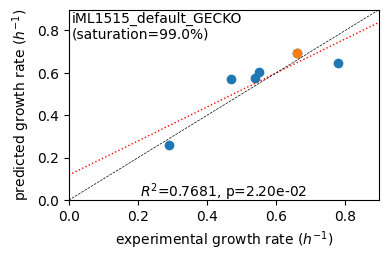

In [19]:
er.plot_grs(exp_grs, highlight='Glucose')

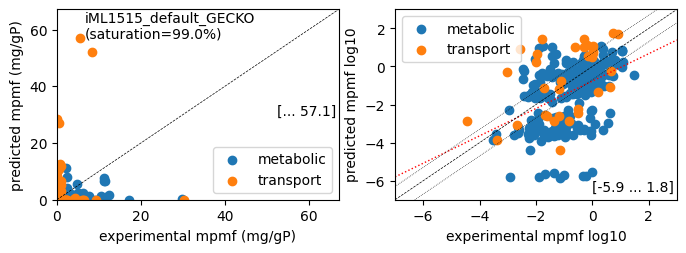

In [20]:
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))    

### Display results in Escher Maps

Escher is a great tool to visualize flux distributions in a network context. Protein and metabolite levels can be displayed as well. Visual inspection of active/inactive pathways and reactions helps qualifying the optimization results. f2xba provides a method for exporting optimization results in a format, that can easily be loaded into Escher maps.

`save_to_escher()` exports optimization results to files readable by the Escher web portal. Records with absolute values < 10-8 are not exported. Files can be created for all or for selected conditions. Filenames are constructed from the base name provided. Here we export net fluxes for all conditions and protein concentrations for Glucose.

To visualize our optimization results on Escher, access their web portal (https://escher.github.io), select the map `Central metabolism (iJO1366)` and load the map. Once the network map is displayed, select `Data -> Load reaction data` and select one of the exported files in `./Escher`, e.g. `iML1515_default_GECKO_Glucose_reaction_data.json`.

Escher Maps for **other organisms**:

As we work with iML1515, we rather prefer network maps created from iML1515. Using the Escher web portal, it is not too difficult to generate maps for other organisms either from scratch or by updating existing maps. Escher documentation describes how.

In [21]:
er.save_to_escher(df_net_fluxes, os.path.join('escher', target_model))
er.save_to_escher(df_proteins['Glucose'], os.path.join('escher', target_model))

6 file(s) exported for "Load reaction data" into Escher maps
1 file(s) exported for "Load gene data" into Escher maps


## Step 6: Track progress
Let us track how well this and our upcoming extended models can predict protein concentrations when compared to measurements. We track improvements for our reference condition Glucose.

Below code section is not relevant for extended model generations. We just use it in this and upcoming tutorials to track the results of our model modifications.

In [22]:
import scipy
import numpy as np

number = 1
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = {}
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
predictions[reference_cond] = pd.DataFrame(data, columns=cols).set_index('No')
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters written to  protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033238,0.189723,1018,298


## Closing Remarks
We created a first GECKO model by extending the genome scale metabolic model iML1515 of *E. coli*. Most of the additional parameters required for GECKO were configured with default values and values automatically collected from online resources. We loaded the model in COBRApy and optimized it for maximal growth rate across different growth media conditions. 

While predicted growth rates correlate well with measured growth rates, the correlation of predicted to measured protein concentrations is not very good. E.g., in the linear protein correlation plot we can man proteins where predicted concentrations are far off from the measured values, especially for transport related proteins. 

In the next tutorial we start improving our initial GECKO model by modifying some of the parameters related to transporters. Instead of setting a single default value for all transport reactions, we will configure different kcat values depending on type of transporter. We also redefine some transporter related enzyme compositions. This, hopefully, shall improve our protein predictions.

So, stay tuned.

---
---
##  (alternatively) Load and optimize GECKO model (gurobipy)

Should you have installed gurobipy and Gurobi, you can use an alternative interface for optimization, which can be significantly faster, as it avoids the overhead imposed by COBRApy. The codes for model loading and optimization change slightly from the COBRApy interface. Results analysis does not change.

Media conditions and proteomics data should already be loaded.

Below we will describe:
A.1 model loading (guropipy)
A.2 model optimization (gurobipy)
A.3 results analysis

### A.1 model loading (gurobipy)
Different to the COBRApy interface, our extended model is only loaded by `EcmOptimization`. The COBRApy method ‘ecm.reactions.get_by_id()’ cannot be used, instead use `eo.get_variable_bounds()`, which returns the variable bounds for a single variable or a list of variables.

In [23]:
# Load model using gurobipy
fname = os.path.join('SBML_models', f'{target_model}.xml')
eo = EcmOptimization(fname)                              # ! gurobipy interface
total_protein = eo.get_variable_bounds('V_PC_total')[1]  # ! gurobipy interface
sigma = eo.avg_enz_saturation
all_genes = set(eo.m_dict['fbcGeneProducts']['label'].values)
tx_genes, metab_genes = eo.get_tx_metab_genes()
print(f'total modeled protein: {total_protein:.2f} mg/gDW, average saturation level: {sigma}')
print(f'{len(all_genes)} genes: ({len(tx_genes)}) transporter, ({len(metab_genes)}) metabolic')

SBML model loaded by sbmlxdf: SBML_models/iML1515_default_GECKO.xml (Fri Feb  7 15:11:01 2025)
LP Model of iML1515_GECKO
7372 variables, 3393 constraints, 28650 non-zero matrix coefficients
total modeled protein: 316.75 mg/gDW, average saturation level: 0.99
1515 genes: (498) transporter, (1017) metabolic


### A.2 model optimization (gurobipy)
Within the optimization loop, use `eo.set_medium()` to configure the medium and `eo.optimize()` for optimization. A model context ('with' statement) is not supported.

In [24]:
# Optimize model using gurobipy
pred_results = {}
for cond, medium in conditions.items():
    eo.set_medium(medium)                   # ! gurobipy interface
    solution = eo.optimize()                # ! gurobipy interface
    if solution.status == 'optimal':
        gr = solution.objective_value
        pred_results[cond] = solution
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')

Acetate                  : pred gr: 0.261 h-1 vs. exp 0.290, diff: -0.029
Glycerol                 : pred gr: 0.569 h-1 vs. exp 0.470, diff:  0.099
Fructose                 : pred gr: 0.575 h-1 vs. exp 0.540, diff:  0.035
L-Malate                 : pred gr: 0.603 h-1 vs. exp 0.550, diff:  0.053
Glucose                  : pred gr: 0.691 h-1 vs. exp 0.660, diff:  0.031
Glucose 6-Phosphate      : pred gr: 0.648 h-1 vs. exp 0.780, diff: -0.132


### A.3 results analysis
This code section is identical to the results analysis used for COBRApy interface.

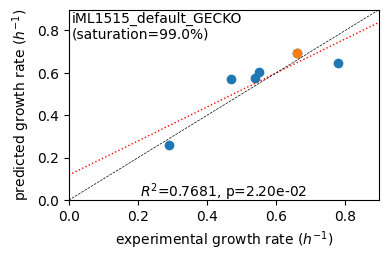

Protein mass fractions:
Acetate                  : r² = 0.0631, p = 4.07e-16 (1018 proteins lin scale)
Glycerol                 : r² = 0.0532, p = 9.12e-14 (1018 proteins lin scale)
Fructose                 : r² = 0.1060, p = 1.42e-26 (1018 proteins lin scale)
Glucose                  : r² = 0.0332, p = 4.66e-09 (1018 proteins lin scale)
Acetate                  : r² = 0.1808, p = 7.24e-15 ( 306 proteins log scale)
Glycerol                 : r² = 0.1569, p = 5.65e-13 ( 307 proteins log scale)
Fructose                 : r² = 0.1556, p = 9.21e-13 ( 304 proteins log scale)
Glucose                  : r² = 0.1897, p = 3.15e-15 ( 298 proteins log scale)

condition: Glucose
1515 proteins in model with total predicted mass fraction of 555.7 mg/gP
     1018 have been measured with mpmf of  555.6 mg/gP vs. 426.5 mg/gP predicted
           777 metabolic proteins measured 423.9 mg/gP vs. 181.3 mg/gP predicted
           241 transport proteins measured 131.7 mg/gP vs. 245.2 mg/gP predicted
      49

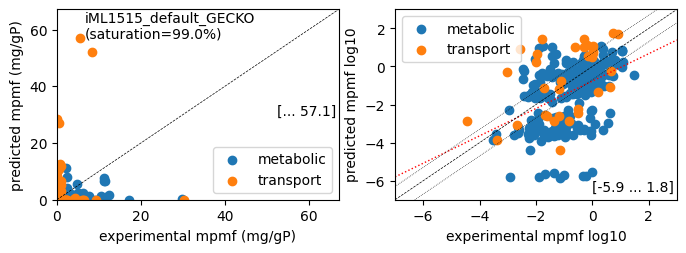

1 file(s) exported for "Load reaction data" into Escher maps


In [25]:
# Analyse results
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight='Glucose')
print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.report_protein_levels('Glucose')
er.plot_proteins('Glucose', plot_fname=os.path.join('plots', f'{target_model}_proteins_Glucose.pdf'))    
er.save_to_escher(df_net_fluxes['Glucose'], os.path.join('escher', target_model))